In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import joblib




In [3]:
data = pd.read_csv("with_HardwareTroj.csv").drop("HT", axis=1)

In [4]:
data

,Impedance,Resistance,Reactance
0,272.31,-40.10,7.860000e-10
1,260.33,-44.83,6.830000e-10
2,58.97,0.43,1.290000e-08
3,272.55,-40.55,7.140000e-10
4,253.93,-42.68,6.610000e-10
...,...,...,...
9996,113.23,226.35,2.410000e-08
9997,115.99,227.68,2.420000e-08
9998,114.70,227.70,2.420000e-08
9999,113.99,225.01,2.400000e-08


In [5]:
# Select the columns you want to predict
columns_to_predict = ['Impedance', 'Resistance', 'Reactance']


In [6]:
sequence_length = 5 

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i+sequence_length][columns_to_predict].values)
        y.append(data.iloc[i+sequence_length][columns_to_predict].values)
    return np.array(X), np.array(y)

X, y = create_sequences(data, sequence_length)

In [7]:
y.shape

(9996, 3)

In [8]:
X.shape

(9996, 5, 3)

In [9]:
# Define the split ratio (e.g., 80% train, 20% test)
split_ratio = 0.8

# Calculate the split index
split_index = int(len(X) * split_ratio)

# Split the data into train and test sets
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [10]:
print(X_train.shape, X_test.shape)

(7996, 5, 3) (2000, 5, 3)


In [11]:
print(y_train.shape, y_test.shape)

(7996, 3) (2000, 3)


In [12]:
# Create the model
model = Sequential()

model.add(LSTM(128, input_shape=(sequence_length, len(columns_to_predict)), activation='relu', return_sequences=True))

model.add(LSTM(64, activation='relu'))  
model.add(Dropout(0.001))

model.add(Dense(len(columns_to_predict)))

# Compile the model with custom learning rate
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            67584     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 117187 (457.76 KB)
Trainable params: 117187 (457.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, verbose=1, callbacks=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3))


Epoch 1/60
200/200 [==============================] - 9s 21ms/step - loss: 3921.1602 - val_loss: 6497.2295
Epoch 2/60
200/200 [==============================] - 3s 15ms/step - loss: 3237.8186 - val_loss: 5366.1323
Epoch 3/60
200/200 [==============================] - 3s 15ms/step - loss: 2125.2764 - val_loss: 3548.6274
Epoch 4/60
200/200 [==============================] - 3s 15ms/step - loss: 1094.9971 - val_loss: 2330.3711
Epoch 5/60
200/200 [==============================] - 3s 15ms/step - loss: 670.6020 - val_loss: 1496.2595
Epoch 6/60
200/200 [==============================] - 3s 15ms/step - loss: 427.9792 - val_loss: 975.5010
Epoch 7/60
200/200 [==============================] - 3s 16ms/step - loss: 294.7584 - val_loss: 699.9648
Epoch 8/60
200/200 [==============================] - 3s 17ms/step - loss: 221.6101 - val_loss: 515.7224
Epoch 9/60
200/200 [==============================] - 3s 15ms/step - loss: 173.6702 - val_loss: 428.3441
Epoch 10/60
200/200 [=========================

Text(0.5, 1.0, 'Loss Curves')

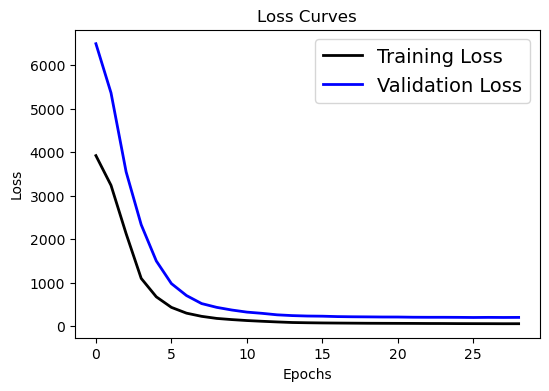

In [15]:
# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [16]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

63/63 [==============================] - 1s 5ms/step - loss: 36.2011
Test Loss: 36.20109939575195


In [17]:
predictions = model.predict(X_train)

250/250 [==============================] - 2s 6ms/step


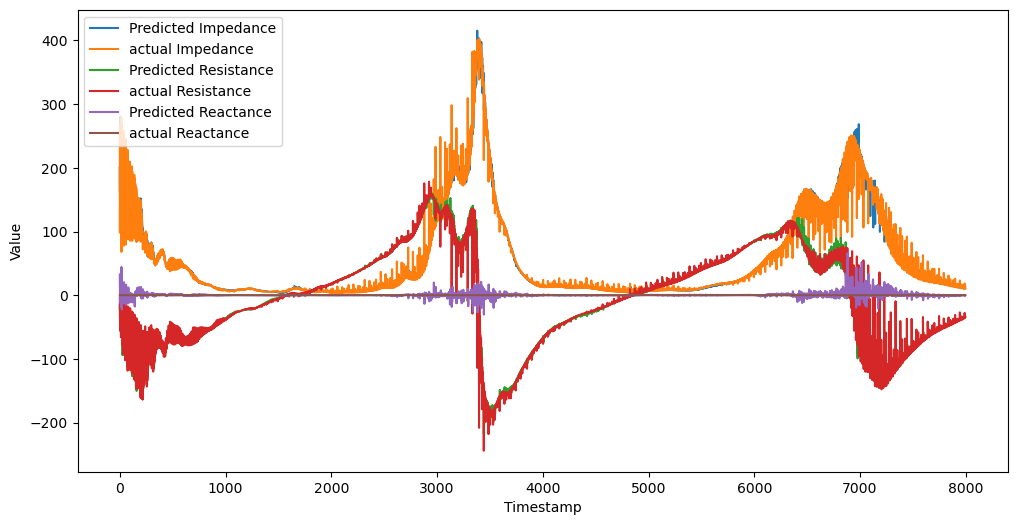

In [18]:
#plotting the train vs predicted 

plt.figure(figsize=(12, 6))
for i, column in enumerate(columns_to_predict):
    plt.plot(predictions[:, i], label=f'Predicted {column}')
    plt.plot(y_train[:, i], label=f'actual {column}')

plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

In [19]:
predictions = model.predict(X_test)

63/63 [==============================] - 0s 6ms/step


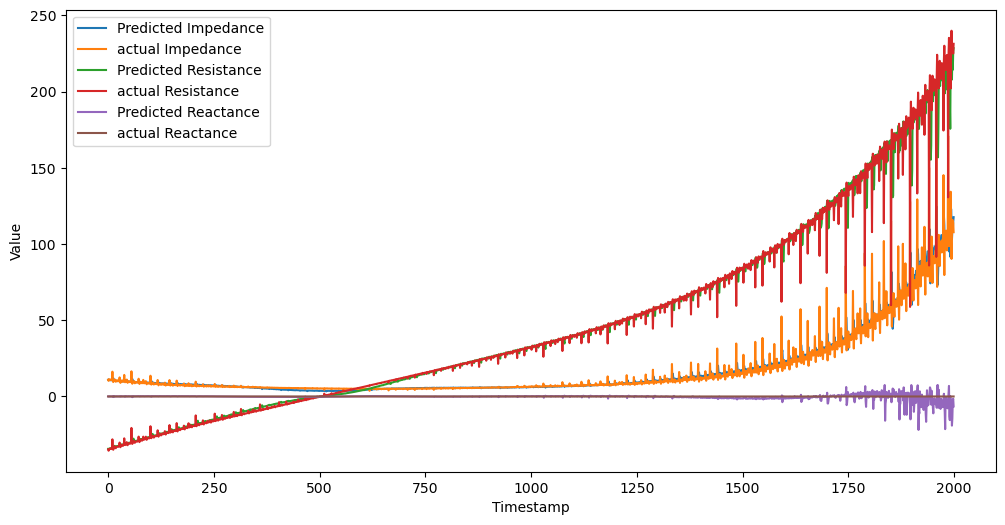

In [20]:
# plotting the test vs predicted

plt.figure(figsize=(12, 6))
for i, column in enumerate(columns_to_predict):
    plt.plot(predictions[:, i], label=f'Predicted {column}')
    plt.plot(y_test[:, i], label=f'actual {column}')


plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

comparing the predicted values vs actual values for our test dataset.

In [21]:
pd.DataFrame(model.predict(X_test))

63/63 [==============================] - 0s 6ms/step


,0,1,2
0,11.010071,-34.379650,0.046605
1,11.094292,-34.375454,-0.054589
2,10.862301,-34.353230,-0.074129
3,10.770708,-34.237507,0.121216
4,10.694631,-34.003269,0.138780
...,...,...,...
1995,103.070183,207.964996,-19.130415
1996,108.947639,224.274277,-14.242020
1997,108.400711,214.375198,-2.583895
1998,114.535110,226.186859,-1.466438


In [22]:
pd.DataFrame(y_test)

,0,1,2
0,10.92,-34.81,3.820000e-12
1,10.25,-35.60,3.730000e-12
2,11.21,-34.63,3.840000e-12
3,11.29,-34.58,3.840000e-12
4,11.14,-34.39,3.860000e-12
...,...,...,...
1995,113.23,226.35,2.410000e-08
1996,115.99,227.68,2.420000e-08
1997,114.70,227.70,2.420000e-08
1998,113.99,225.01,2.400000e-08


In [112]:
data[8000:8006]

,Impedance,Resistance,Reactance
8000,12.41,-33.61,3.960000e-12
8001,10.92,-34.81,3.820000e-12
8002,10.25,-35.60,3.730000e-12
8003,11.21,-34.63,3.840000e-12
8004,11.29,-34.58,3.840000e-12
8005,11.14,-34.39,3.860000e-12


In [122]:

# assign your new dataset to new_data variable..
new_data = data[8000:8006]


# Create sequences for prediction
X_new = []


for i in range(len(new_data) - sequence_length):
    X_new.append(new_data[columns_to_predict].iloc[i:i+sequence_length].values)

X_new = np.array(X_new)

# Make predictions
predictions = model.predict(X_new)

pd.DataFrame(predictions)

1/1 [==============================] - 0s 37ms/step


,0,1,2
0,10.694628,-34.003262,0.138782


In [123]:
pd.DataFrame(new_data)

,Impedance,Resistance,Reactance
8000,12.41,-33.61,3.960000e-12
8001,10.92,-34.81,3.820000e-12
8002,10.25,-35.60,3.730000e-12
8003,11.21,-34.63,3.840000e-12
8004,11.29,-34.58,3.840000e-12
8005,11.14,-34.39,3.860000e-12


In [125]:
# Number of recursive predictions you want to make
num_predictions = 3

# Create a list to store the predictions
recursive_predictions = []

for _ in range(num_predictions):
    # Reshape the last sequence for prediction
    input_data = X_new[-1].reshape(1, sequence_length, len(columns_to_predict))
    
    # Make a prediction for the next time step
    prediction = model.predict(input_data)[0]
    
    # Append the prediction to the list
    recursive_predictions.append(prediction)
    
    # Update the input data for the next prediction
    X_new[-1] = np.vstack((X_new[-1][1:], prediction))

    

# Print the recursive predictions
print("Recursive Predictions:")
rec_preds = pd.DataFrame(recursive_predictions,columns= ['Impedance', 'Resistance', 'Reactance'])
rec_preds

1/1 [==============================] - 0s 36ms/step
Recursive Predictions:


,Impedance,Resistance,Reactance
0,10.577870,-33.962730,0.057994
1,10.464794,-33.691525,0.081332
2,10.369907,-33.316219,0.101726


In [126]:

# Specify the file path where the model is saved
model_filename = 'random_forest_model.pkl'
loaded_rf = joblib.load(model_filename)

print(f"{model_filename} loaded in the notebook and ready for predictions")


random_forest_model.pkl loaded in the notebook and ready for predictions


In [127]:
# Now, you can use the loaded model for predictions
loaded_rf.predict(rec_preds)

array([1, 1, 1], dtype=int64)